# Math with Numpy & Dask

In this notebook we use numpy and dask to implement a linear function, numerical integration and an ordinary differential equation and we look at the corresponding dask graphs. Every section contains a short explanation of the math and a few lines of code that show how the math is implemented. Numpy arrays and helper functions have an underscore at their names.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da
from dask.dot import dot_graph

## Linear Function

Let's start with a simple linear function:

$$ A\cdot x + b $$

In order to make the graph plot readable we use a small $2\times2$ matrix.

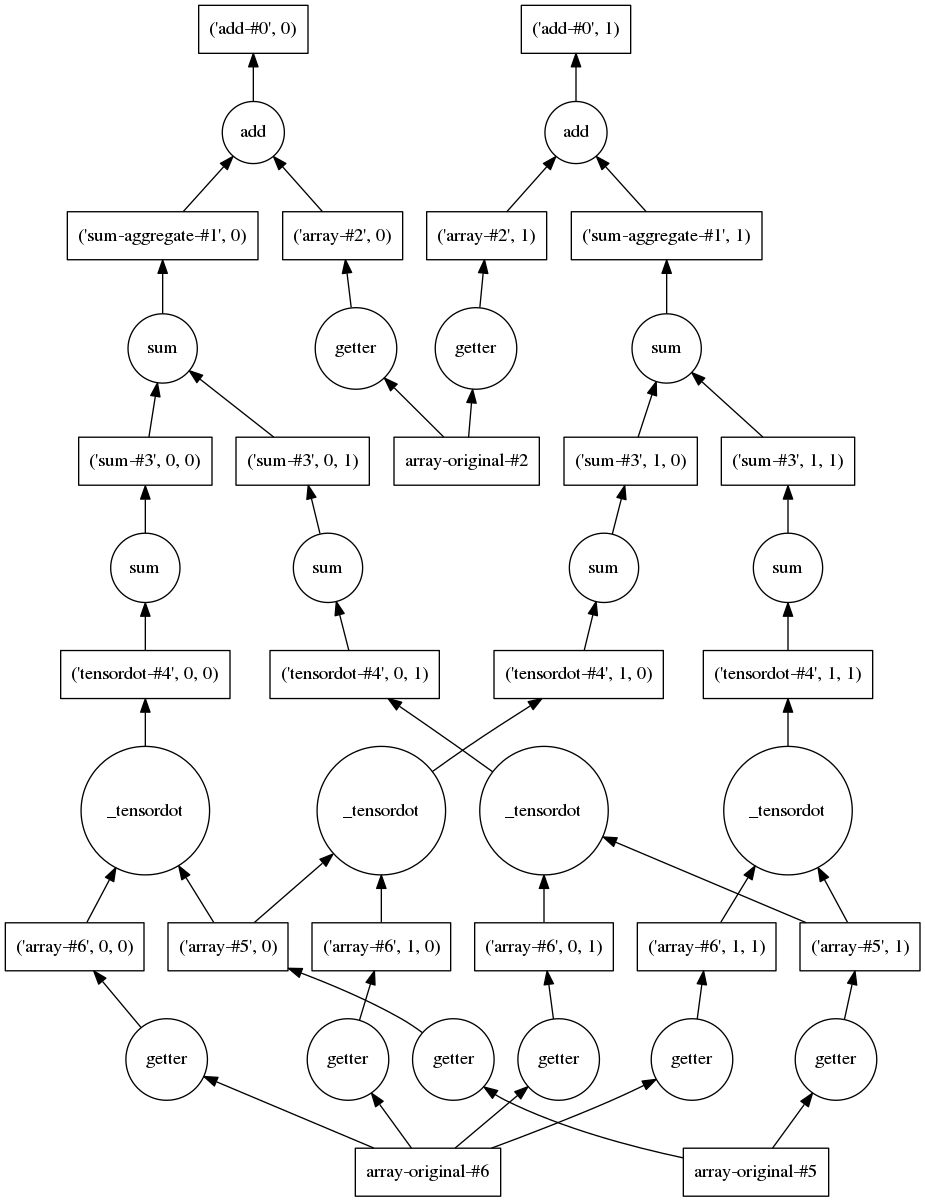

In [2]:
A_ = np.random.random((2, 2))
A = da.from_array(A_, chunks=(1))
    
x_ = np.random.random(2)
x = da.from_array(x_, chunks=(1))

b_ = np.random.random(2)
b = da.from_array(b_, chunks=(1))

g = (A @ x + b)
dot_graph(g.dask)

## Numerical Integration

Next we want to look at numerical integration which usually means a weighted sum:

$$ \int_a^b f(x) ~dx \rightarrow \sum_{i=1}^n w_i f(x_i)$$

For our example we use $f(x) = A\cdot x + c$ and $x_j = j\frac{(b-a)}{n}$. The weights $w_j$ are dummy values. Note that for an actual numerical integration you want to choose the nodes and their weights more carefully, e.g. like this: https://en.wikipedia.org/wiki/Numerical_integration#Quadrature_rules_based_on_interpolating_functions

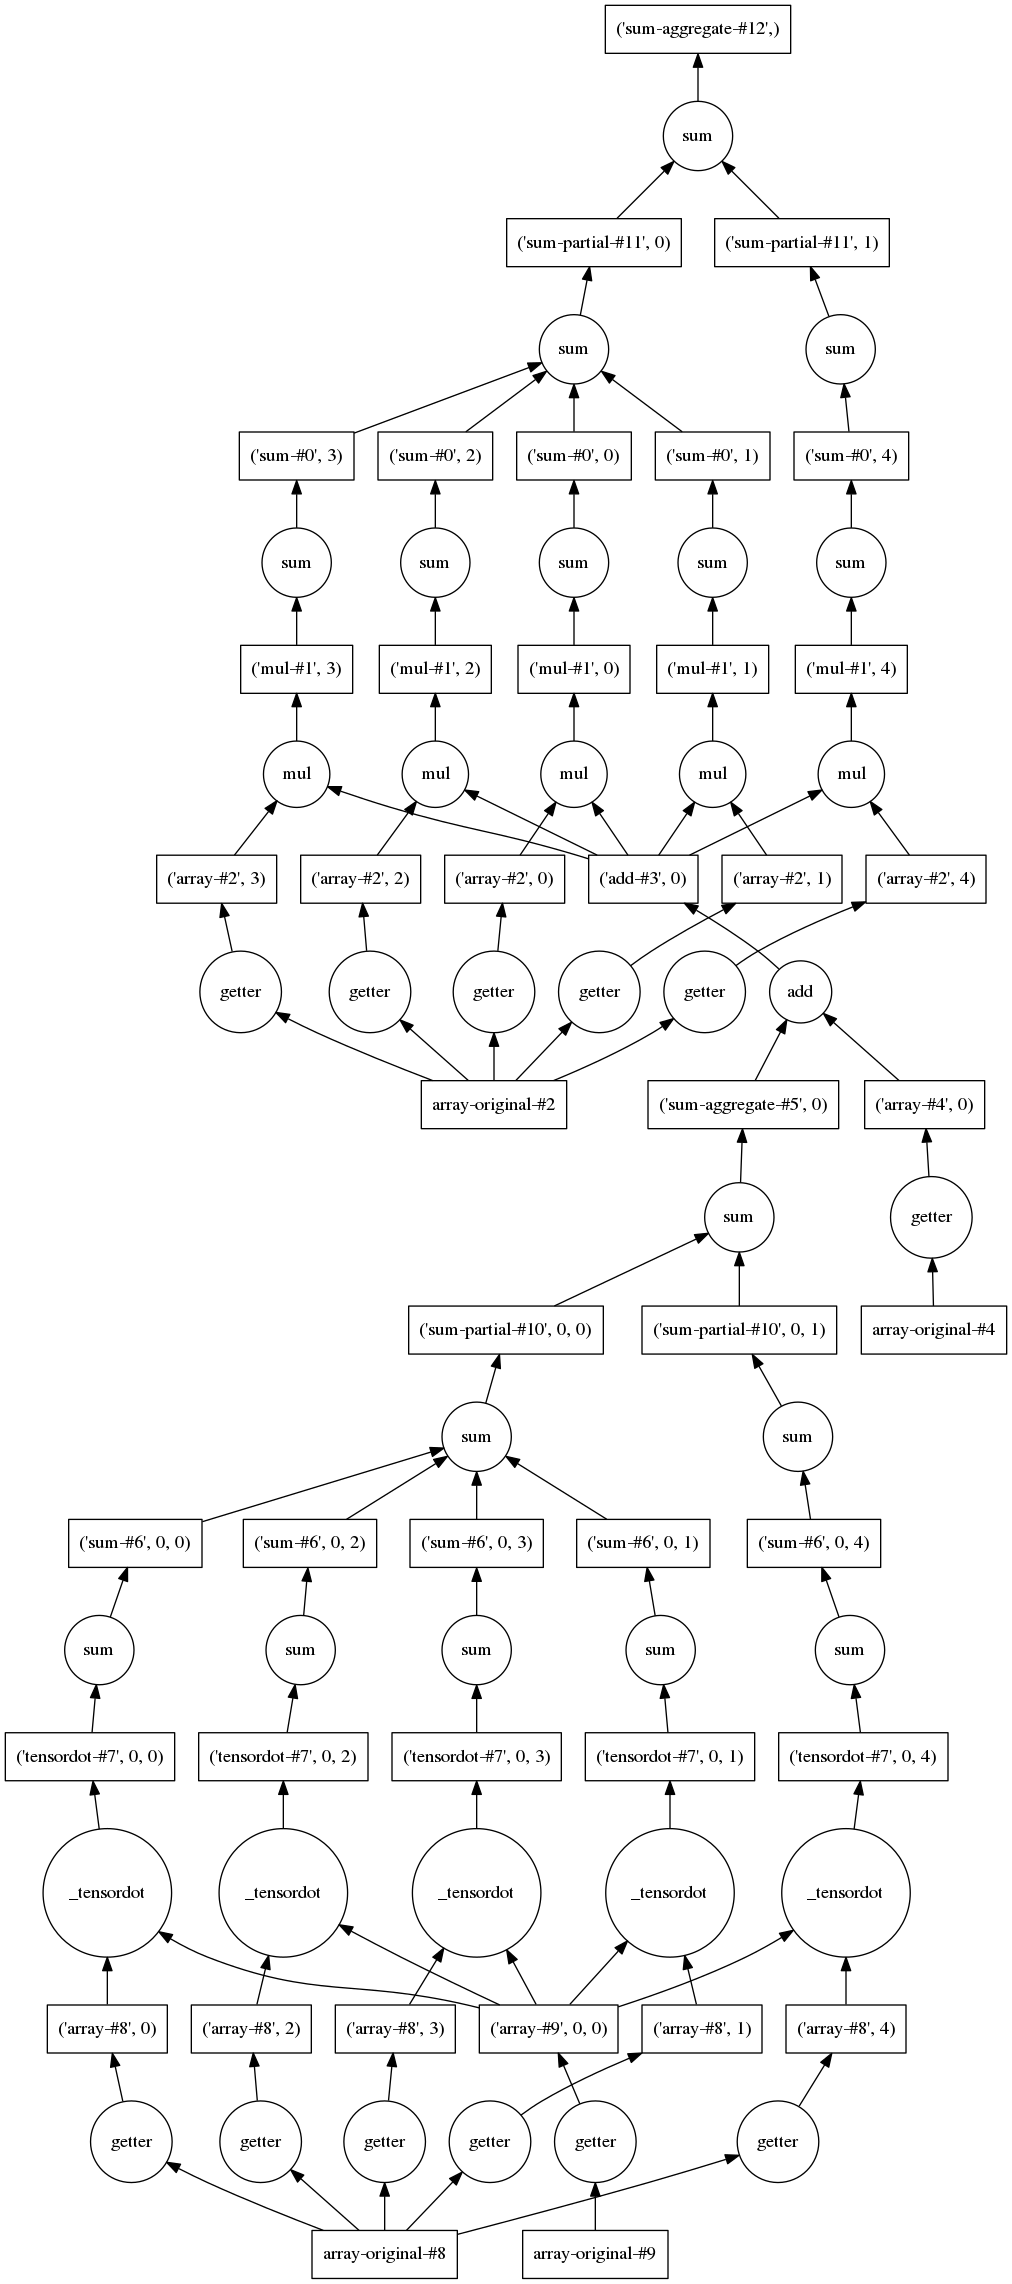

In [3]:
n = 10
a, b = 0, 1
    
x_ = np.arange(a, b, (b-a)/n)
x = da.from_array(x_, chunks=(2))
    
A_ = np.random.random((1, 1))
A = da.from_array(A_, chunks=(2))
    
c_ = np.random.random(1)
c = da.from_array(c_, chunks=(2))
    
f_ = lambda x: A @ x + c
    
w_ = np.random.random(n)
w = da.from_array(w_, chunks=(2))
    
g = (w * (f_(x))).sum()
dot_graph(g.dask)

## Ordinary Differential Equation

And finally we want to solve a ordinary differential equation of order one:

\begin{align}
u'(x) &= f(x, u(x)) \\
u(x_0) &= a
\end{align}

We want to solve a problem like this on an interval $[a,b]$.
First we discretize the problem to $x_j = a + jh$ with $j=0,1,\dots,N$ and $h=\frac{b-a}{N}$. Now we can replace the derivatives with differences and write $u_j := u(x_j)$. Using a simple forward method we get

\begin{align}
u_j = u_{j-1} + hf(x_{j-1}, u_{j-1})
\end{align}

For our example we use the simple ODE $u'(x) = u(x), u(0) = 1$ to which the solution is obviously $e^x$. And we rewrite the forward method so it only depends on $u_0$:

\begin{align}
u_0 &= u_0\\
u_1 &= u_0 + hu_0 = u_0(1+h)\\
u_2 &= u_1 + hu_1 = u_0(1+h)^2\\
&\vdots
\end{align}

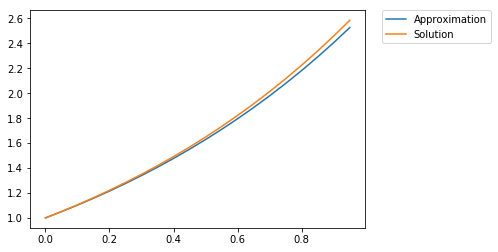

In [4]:
n = 20
a, b = 0, 1
h = (b-a)/n
u0 = 1

H_ = lambda x: (1 + h)**x
H = da.from_array(np.arange(n), chunks=(2))

u = (u0 * H_(H))

X = np.array([a + j*h for j in range(n)])

plt.plot(X, u.compute(), label="Approximation")
plt.plot(X, np.exp(X), label="Solution")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

The plot shows the solution to the ODE as well as our approximation. Also this is the first time in this notebook that we actually compute a dask graph. In our example the variable $u$ contains the dask graph for our computation and with $u.compute()$ we get the result. The corrresponding graph plot is here:

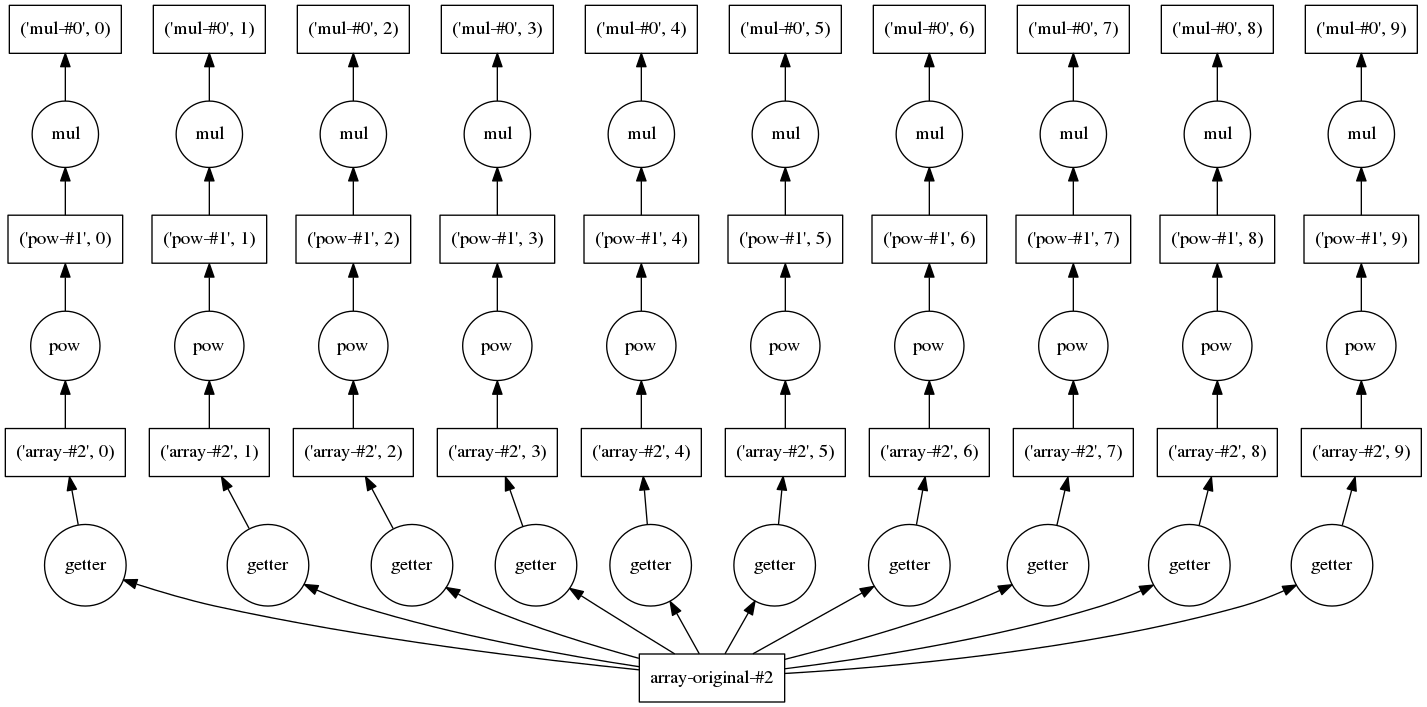

In [5]:
dot_graph(u.dask)